In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from graspy.simulations import binary_sbm
from graspy.utils import symmetrize
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

$$(G_1, G_2) \sim \rho SBM(k,b,\Lambda)$$
$$b: V \to \{1,\dots,n\}, \Lambda \in \mathbb{R}^{kxk}$$
First, evaluate for ER random graphs:
$$|V_1|=|V_2|=100$$
$$k = 1, b = V \to 1$$
And sweep over values of $\Lambda$ from $[0] \to [1]$ and $\rho$ from $0$ to $1$

In [2]:
def rho_ER(rho,p,n=100):
    """
    Parameters
    ----------
    rho : float, int
        edge correlation between ER random graphs
    p : float, int
        probability of edge within graph
    n : int, optional
        number of vertices in graph
        
    Returns
    -------
    A : array-like
        The adjacency matrix of graph G1
    B : array-like
        The adjacency matrix of graph G2
    """
    nvec = [100]
    pvec = np.array([[p]])
    L = np.repeat(np.repeat(pvec,100,0),100,1)

    A = binary_sbm(nvec, pvec)
    B = np.random.binomial(1,(1-rho)*L + rho*A)
    np.fill_diagonal(B,0)
    
    return A,B

In [222]:
def rho_sbm(k,rho,L,n=100):
    """
    Generates 2 adjacency matrices A,B of graphs G1, G2.
    (G1,G2) are sampled from a rho-SBM(k,b,L) by the method described in [1].
    The block membership function assumes the first n//k belong to block 1, and so on.
    
    Parameters
    ----------
    rho : float, int
        correlation between graphs.
        0.0 <= rho <= 1.0
    k : int
        number of blocks of the rho-SBM.
        k >= 1
    L : array-like
        edge probability matrix, each entry a float between 0 and 1.
        L should be of size k by k.
    n : int, optional, default = 100
        number of vertices for each graph
    
    Returns
    -------
    A : array-like
        The adjacency matrix of graph G1
    B : array-like
        The adjacency matrix of graph G2

    References
    ----------
    .. [1] Fishkind et. al (2012).
        Seeded Graph Matching
        arXiv:1209.0367v4
    """
    L = symmetrize(L)
    A = binary_sbm([int(n/k)]*k, L)
    BL = np.repeat(np.repeat(L,n//k,0),n//k,1)
    B = np.random.binomial(1,(1-rho)*BL + rho*A)
    np.fill_diagonal(B,0)
    return A,B

In [223]:
def double_plot(A, B):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.heatmap(B, ax=ax[1], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    ax[0].set_title('Adjacency matrix A', fontsize=20)
    ax[1].set_title('Adjacency matrix B',fontsize=20)
    plt.show()
    return

### Visualizing $A,B \sim \rho ER(p)$ with $\rho=0.9, p=0.8$

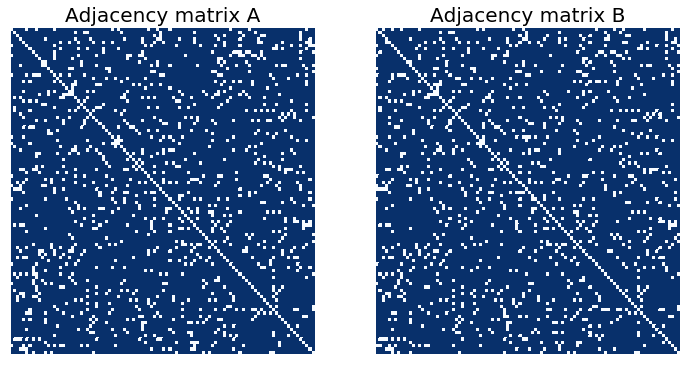

In [224]:
A,B = rho_ER(0.9,0.9)
double_plot(A,B)

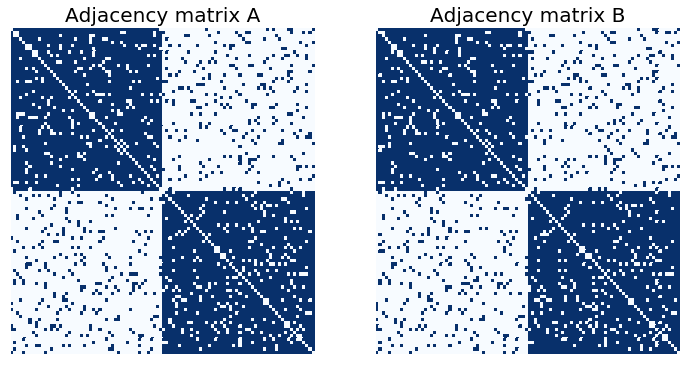

In [245]:
A2,B2 = rho_sbm(2,0.9,np.array([[0.9,.1],[.1,.9]]))
double_plot(A2,B2)

In [204]:
def triu_no_diag(A):
    n = A.shape[0]
    iu1 = np.triu_indices(n,1)
    return A[iu1]

In [246]:
def rho_h(nvec, pvec):
    mu = np.sum(np.multiply(nvec,pvec))/np.sum(nvec)
    var1 = np.square(np.subtract(pvec,mu))
    var = np.sum(np.multiply(nvec,var1))/np.sum(nvec)
    rhoh = np.nan_to_num(var/(mu*(1-mu)))
    return rhoh 

def rho_t(nvec, pvec, rhoe):
    """
    Parameters
    ----------
    nvec : array-like(int)
        list of block sizes
    pvec : array-like(float)
        list of block probabilities
    rhoe : float
        edge correlation between two graphs
        
    Returns
    -------
    rhot : frac
        total correlation between graphs
    """
    rhoh = rho_h(nvec,pvec)
    rhot = 1-(1-rhoe)*(1-rhoh)
    return rhot

def rho_e(nvec, pvec, rhot):
    """
    Parameters
    ----------
    nvec : array-like(int)
        list of block sizes
    pvec : array-like(float)
        list of block probabilities
    rhot : float
        total correlation between two graphs
        
    Returns
    -------
    rhoe : frac
        edge correlation between graphs
    """
    rhoh = rho_h(nvec,pvec)
    rhoe = 1 - (1-rhot)/(1-rhoh)
    return rhoe

def corr(A,B):
    A2 = triu_no_diag(A)
    B2 = triu_no_diag(B)
    x = np.vstack((A2,B2))
    return np.corrcoef(x)[0,1]

In [213]:
def d(A,B):
    n = A.shape[0]
    count = 0
    diffs = []
    for l in combinations(range(n),2):
        Al = A[l[0],l[1]]
        Bl = B[l[0],l[1]]
        diff = np.abs(np.subtract(Al,Bl))
        diffs.append(diff)
    return np.sum(diffs)

def d2(A,B):
    A2 = triu_no_diag(A)
    B2 = triu_no_diag(B)
    C = np.sum(np.abs(A2-B2))
    return C

def alignment_strength(A,B,phi=np.eye(A.shape[0])):
    n = A.shape[0]
    #B2 = np.matmul(B,phi)
    nfact = n*(n-1)//2
    dg = np.sum(A)/nfact
    dh = np.sum(B)/nfact
    strength = 1-(d(A,B)/nfact)/(dg*(1-dh)+dh*(1-dg))
    return strength

def alignment_strength2(A,B,phi=np.eye(A.shape[0])):
    n = A.shape[0]
    #B2 = np.matmul(B,phi)
    nfact = n*(n-1)//2
    dg = np.sum(A)/nfact
    dh = np.sum(B)/nfact
    strength = 1-(d2(A,B)/nfact)/(dg*(1-dh)+dh*(1-dg))
    return strength

def estimate_rhoe(A,B,nvec,pvec,phi=np.eye(A.shape[0])):
    rhot = alignment_strength(A,B,phi)
    rhoe = rho_e(nvec,pvec,rhot)
    return rhoe

def estimate_rhoe2(A,B,nvec,pvec,phi=np.eye(A.shape[0])):
    rhot = alignment_strength2(A,B,phi)
    rhoe = rho_e(nvec,pvec,rhot)
    return rhoe

In [215]:
def plotly_plot(x,y,z):
    data = []
    for z_item in z:
        data.append(
            go.Surface(
                x=x,
                y=y,
                z=z_item,
                opacity=0.7,
                showscale=False)
        )

    layout = go.Layout(
        title='rho-ER',
        autosize=False,
        scene = dict(
            xaxis = dict(
                title='rho_e'),
            yaxis = dict(
                title='p'),
            zaxis = dict(
                title='hat(rho_e)') 
        ),
        width=750,
        height=750,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )

    return go.Figure(data=data, layout=layout)

In [208]:
def gen_surface(func, rho_n=11, p_n=11):
    """
    Parameters
    ----------
    func : function
        should take adjacency matrices A and B and return a scalar value
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    z = z_err = np.zeros((rho_n,p_n))
    for i,rho in enumerate(np.linspace(0,1,rho_n)):
        for j,p in enumerate(np.linspace(0,1,p_n)):
            monte = []
            for _ in range(100):
                A,B = rho_ER(rho,p)
                monte.append(np.nan_to_num(corr(A,B)))
            z[i,j] = np.mean(monte)
            z_err[i,j] = np.std(monte)
    return z, z_err

def gen_rhoehat(p_n=11,rho_n=11):
    """
    Parameters
    ----------
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    x = np.linspace(0,1,p_n)
    y = np.linspace(0,1,rho_n)
    z = np.zeros((p_n,rho_n))
    z2 = np.zeros((p_n,rho_n))
    for i,p in tqdm(enumerate(x)):
        for j,rho in enumerate(y):
            monte = []
            monte2 = []
            for _ in range(10):
                A,B = rho_ER(rho,p)
                monte.append(estimate_rhoe(A,B,[100],[p]))
                monte2.append(rho_t([100],[p],rho))
            z[i,j] = np.mean(monte)
            z2[i,j] = np.mean(monte2)
    fig = plotly_plot(y,x,[z,z2])
    return fig

In [209]:
def gen_ER_surf(func,p_n=11,rho_n=11):
    """
    Parameters
    ----------
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    x = np.linspace(0,1,p_n)
    y = np.linspace(0,1,rho_n)
    z = np.zeros((p_n,rho_n))
    zerr = np.zeros((p_n,rho_n))
    z2 = np.zeros((p_n,rho_n))
    for i,p in tqdm(enumerate(x)):
        for j,rho in enumerate(y):
            monte = []
            monte2 = []
            for _ in range(10):
                A,B = rho_ER(rho,p)
                monte.append(func(A,B))
                monte2.append(rho_t([100],[p],rho))
            z[i,j] = np.mean(monte)
            zerr[i,j] = np.std(monte)
            z2[i,j] = np.mean(monte2)
    fig = plotly_plot(y,x,[z,z2])
    print(np.linalg.norm(np.nan_to_num(zerr)))
    return fig

In [249]:
def gen_SBM_surf(func,p_n=11,rho_n=11):
    """
    Parameters
    ----------
    rho_n : int, optional, default = 11
        the number of values of rho between 0 and 1
    p_n : int, optional, default = 11
        the number of values of p between 0 and 1
    """
    x = np.linspace(0,1,p_n)
    y = np.linspace(0,1,rho_n)
    z = np.zeros((p_n,rho_n))
    zerr = np.zeros((p_n,rho_n))
    z2 = np.zeros((p_n,rho_n))
    for i,p in tqdm(enumerate(x)):
        for j,rho in enumerate(y):
            monte = []
            monte2 = []
            for _ in range(10):
                L = np.array([[p,.1],[.1,p]])
                A,B = rho_sbm(2,rho,L)
                monte.append(func(A,B))
                #monte2.append(rho_e([50,50],np.array([[p,.1],[.1,.25+p/2]]),rho))
                rhoh = rho_h([50,50],[.9,.9])
                monte2.append(1-(1-rho)*(1-rhoh))
            z[i,j] = np.mean(monte)
            zerr[i,j] = np.std(monte)
            z2[i,j] = np.mean(monte2)
    fig = plotly_plot(y,x,[z,z2])
    print(np.linalg.norm(np.nan_to_num(zerr)))
    return fig

In [250]:
fig = gen_SBM_surf(corr,11,11)
py.iplot(fig)

0.14437134804829543


In [239]:
fig = gen_ER_surf(corr,11,11)
py.iplot(fig)

0.13717325519465512


In [164]:
#why isn't it symmetric?
rho = 0.5
p = 0.99
cs = []
sxs = []
sys = []
ts = []
for _ in range(250):
    A,B = rho_ER(rho,p,n=500)
    A = A.ravel()
    B = B.ravel()
    x = np.vstack((A.ravel(),B.ravel()))
    cs.append(np.corrcoef(x)[0,1])
    sxs.append(np.cov(x)[0,0])
    sys.append(np.cov(x)[1,1])
    ts.append(rho_t([500],[p],rho))
print(np.var(A.ravel()))
print('rho:', rho, 'p:', p)
print('vector estimated corr:')
print('mean and std of covariances:', np.mean(cs), np.std(cs))
print('mean and var of var(A):', np.mean(sxs), np.std(sxs))
print('mean and var of var(B):', np.mean(sys), np.std(sys))
print('mean and std of true calculated corr:', np.mean(ts), np.std(ts))

print('pero!')

rho = 0.5
p = 0.01
cs = []
sxs = []
sys = []
ts = []
for _ in range(250):
    A,B = rho_ER(rho,p,n=500)
    A = A.ravel()
    B = B.ravel()
    x = np.vstack((A.ravel(),B.ravel()))
    cs.append(np.corrcoef(x)[0,1])
    sxs.append(np.cov(x)[0,0])
    sys.append(np.cov(x)[1,1])
    ts.append(rho_t([500],[p],rho))
print(np.var(A.ravel()))
print('rho:', rho, 'p:', p)
print('vector estimated corr:')
print('mean and std of covariances:', np.mean(cs), np.std(cs))
print('mean and var of var(A):', np.mean(sxs), np.std(sxs))
print('mean and var of var(B):', np.mean(sys), np.std(sys))
print('mean and std of true calculated corr:', np.mean(ts), np.std(ts))

0.02132476
rho: 0.5 p: 0.99
vector estimated corr:
mean and std of covariances: 0.7501590345100072 0.02189550388548202
mean and var of var(A): 0.01961584846484648 0.0014371525689139085
mean and var of var(B): 0.019559654725472556 0.0010568395782958795
mean and std of true calculated corr: 0.5 0.0
pero!
0.008919
rho: 0.5 p: 0.01
vector estimated corr:
mean and std of covariances: 0.4997913200577259 0.04645690082936522
mean and var of var(A): 0.009827494269426943 0.0014331309829958782
mean and var of var(B): 0.009836390079007901 0.00119127880885188
mean and std of true calculated corr: 0.5 0.0


In [214]:
fig = gen_ER_surf(alignment_strength2,101,101)
py.iplot(fig)

192632.767366717


In [133]:
fig = gen_ER_surf(alignment_strength,101,101)
py.iplot(fig)

31459.467050623152


In [134]:
fig2 = gen_rhoehat(101,101)
py.iplot(fig2)